# Logistic regression

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [91]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [92]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py

In [93]:
from utils import set_pyplot_params
set_pyplot_params()

## Generational Changes

As a second example of logistic regression, we'll use data from the [General Social Survey](https://gss.norc.org/) (GSS) to describe generational changes in support for legalization of marijuana.

Since 1972 the GSS has surveyed a representative sample of adults in the U.S., asking about issues like "national spending priorities, crime and punishment, intergroup relations, and confidence in institutions".

I have selected a subset of the GSS data, resampled it to correct for stratified sampling, and made the results available in an HDF file.

The following cell downloads the data.

In [61]:
# Load the data file

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/gss_eda.hdf5

We can use Pandas to load the data.

In [62]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 169)

The result is a `DataFrame` with one row for each respondent and one column for each variable.

The primary variable we'll explore is `grass`, which encodes each respondent's answer to this question ([details here](https://gssdataexplorer.norc.org/variables/285/vshow)):

> "Do you think the use of marijuana should be made legal or not?"

This question was asked during most years of the survey starting in 1973, so it provides a useful view of changes in attitudes over almost 50 years.

Here are is the distributions of responses:

In [63]:
gss['grass'].value_counts(dropna=False)

NaN    27268
2.0    25662
1.0    11884
Name: grass, dtype: int64

The value 1.0 represents "yes"; 2.0 represents "no"; `NaN` represents peope who were not asked the question and a small number of respondents who did not respond or said "I don't know".

To explore generational changes in the responses, we will look at the level of support for legalization as a function of birth year, which is encoded in a variable called `cohort`.  Here's a summary of this variable.

In [64]:
gss['cohort'].describe()

count    64586.000000
mean      1948.846069
std         21.262659
min       1883.000000
25%       1934.000000
50%       1951.000000
75%       1964.000000
max       2000.000000
Name: cohort, dtype: float64

The oldest GSS respondent was born in 1883; the youngest was born in 2000.

Before we analyze this data, I will select the subset of respondents with valid data for `grass` and `cohort`:

In [65]:
valid = gss.dropna(subset=['grass', 'cohort']).copy()
valid.shape

(37427, 169)

There are about 37,000 respondents with the data we need.

I'll recode the values of `grass` so `1` means yes and `0` means no.

In [66]:
valid['y'] = valid['grass'].replace(2, 0)
valid['y'].value_counts()

0.0    25572
1.0    11855
Name: y, dtype: int64

Now, for this problem, I'm going to represent the data in a different format.  Rather than one row for each respondent, I am going to group the respondents by birth year and record the number of respondents in each group, `count`, and the number who support legalization, `sum`.

In [67]:
data = valid.groupby('cohort')['y'].agg(['sum', 'count'])
data

,sum,count
cohort,,
1884.0,0.0,1
1886.0,0.0,3
1887.0,1.0,9
1888.0,0.0,3
1889.0,1.0,14
...,...,...
1996.0,40.0,47
1997.0,28.0,41
1998.0,11.0,17


Here's what the results look like:

In [68]:
def plot_data(data):
    """Plot the fraction of yes responses.
    
    data: DataFrame with columns `sum` and `count`
    """
    fraction = data['sum'] / data['count']
    plt.plot(data.index, fraction, 'o', 
             label='GSS data', color='C0', alpha=0.4)
    
    decorate(xlabel='Year of birth',
             ylabel='Percent in favor',
             title='Support for legal marijuana vs cohort')

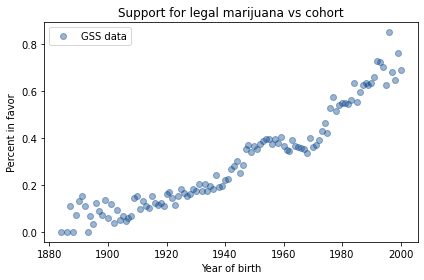

In [69]:
plot_data(data)

There is a strong relationship between birth year and support for legalization.  People born before 1920 are the least likely to say "yes"; people born after 1990 are the most likely. 

There are substantial departures from the long-term trend for people born in the 1950s and late 1960s.  If you want to conjecture about the causes, it might help to think about what was happening when each group turned 18.  People born in 1950 turned 18 during [the counterculture of the 1960s](https://en.wikipedia.org/wiki/Counterculture_of_the_1960s).  People born in the late 1960s turned 18 during the "[Just Say No](https://en.wikipedia.org/wiki/Just_Say_No)" era of the War on Drugs and the peak in the AIDS epidemic in the U.S.

## Point estimates

I'll use StatsModels again to generate point estimates for the slope and intercept of a logistic model.

As we did with the previous problem, I'll center the values of the explanatory variable so the mean is 0.

In [70]:
offset = valid['cohort'].mean()
valid['x'] = valid['cohort'] - offset

Here are the results from StatsModels.

In [71]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=valid).fit(disp=0)
results.params

Intercept   -0.849094
x            0.031691
dtype: float64

To visualize the results, I'll use these parameters to estimate the probability of support in each cohort.

In [72]:
inter = results.params['Intercept']
slope = results.params['x']

I'll shift the birth years in `data` by `offset`.

In [73]:
data['x'] = data.index - offset
data.head()

,sum,count,x
cohort,,,
1884.0,0.0,1,-64.724243
1886.0,0.0,3,-62.724243
1887.0,1.0,9,-61.724243
1888.0,0.0,3,-60.724243
1889.0,1.0,14,-59.724243


And use `expit` to compute the probabilities.

In [74]:
probs = expit(inter + slope * data['x'])
probs.head()

cohort
1884.0    0.052141
1886.0    0.055364
1887.0    0.057045
1888.0    0.058774
1889.0    0.060552
Name: x, dtype: float64

Here's what the model looks like with the data.

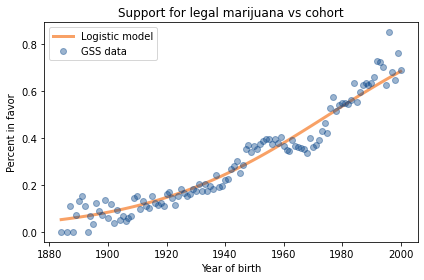

In [75]:
probs.plot(label='Logistic model', color='C1')

plot_data(data)

With these parameters, the model captures the long term trend in the data.

## Computing likelihoods

Before we do the Bayesian update, let's compute the probability of the data with the estimated parameters.

From the data, we know how many people there are in each group and how many of them support legalization.  From the model, we have an estimate for the probability of support in each group.

So we can use the binomial distribution to compute the probability of the data given the estimated probabilities.

In [76]:
from scipy.stats import binom

ks = data['sum']
ns = data['count']
likes = binom.pmf(ks, ns, probs)
likes.shape

(116,)

For each group `likes` contains the probability of the outcome, `k`, given the group size, `n`, and the estimated probability, `p`.

The likelihood of the data is the product of these likelihoods:

In [77]:
likes.prod()

1.5665006815705933e-209

This likelihood is very small, for two reasons:

* The dataset is large, which means that there are many possible outcomes, so the probability of *any* particular outcome is small.

* The data deviate substantially from the model, so the probability of *this* particular outcome is small.

In theory, it's not a problem if the likelihood of the data is small.  We might not get a model that fits the data perfectly, but we'll get the parameters that come as close as possible.

However, in practice small likelihoods can be problematic.  With floating-point numbers, the smallest positive number we can represent is about `1e-1021`.

In [78]:
import sys
sys.float_info.min_exp

-1021

Any number smaller than that "underflows"; that is, it gets rounded down to 0.  When that happens, we lose the ability to distinguish between parameters that make the model fit the data or not.  In the worst case, if all likelihoods underflow, all probabilities in the posterior distribution would be 0.

In this example, the likelihoods are big enough that we can still do a Bayesian update, so we'll do that next.
Then I will demonstrate a trick we can use to avoid underflow: computing likelihoods under a log transformation.

## The update

I'll use uniform priors for the parameters, with locations centered around the point estimates.

In [79]:
qs = np.linspace(-0.95, -0.75, num=51)
prior_inter = make_uniform(qs, 'Intercept')

In [80]:
qs = np.linspace(0.025, 0.035, num=51)
prior_slope = make_uniform(qs, 'Slope')

I'll make a joint prior.

In [81]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-0.950,-0.946,-0.942,-0.938,-0.934,-0.930,-0.926,-0.922,-0.918,-0.914,...,-0.786,-0.782,-0.778,-0.774,-0.770,-0.766,-0.762,-0.758,-0.754,-0.750
Slope,,,,,,,,,,,,,,,,,,,,,
0.0250,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0252,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0254,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0256,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384
0.0258,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,...,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384,0.000384


And stack it into a `Pmf` with a two-column index.

In [82]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
0.025  -0.950       0.000384
       -0.946       0.000384
       -0.942       0.000384
       -0.938       0.000384
       -0.934       0.000384
dtype: float64

Here's the update, using the binomial distribution to compute the likelihood of the data in each group.

In [83]:
likelihood = joint_pmf.copy()

xs = data['x']
ks = data['sum']
ns = data['count']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood[slope, inter] = likes.prod()

Again, the likelihoods are small.

In [84]:
likelihood.sum()

8.656375286337876e-208

But we can do the update in the usual way.

In [85]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

3.328095073563197e-211

And there are enough non-zero elements to get a useful posterior distribution.

Here's what it looks like.

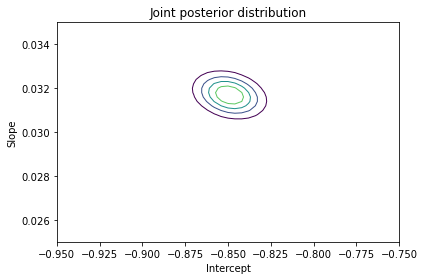

In [86]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

We can confirm that the parameters with maximum posterior probability are consistent with the point estimates.

In [87]:
print(posterior_pmf.max_prob())
print(results.params.values[::-1])

(0.0318, -0.85)
[ 0.0316906  -0.84909407]


Here are the means of the marginal distributions.

In [88]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

(-0.8491556076374563, 0.03169425569628929)

Recall that the intercept indicates the log odds of the hypothesis at `x=0`.
To make the distribution of intercepts easier to interpret, I'll use `expit` to transform the values to probabilities.

In [89]:
marginal_probs = transform(marginal_inter, expit)

And here's what it looks like.

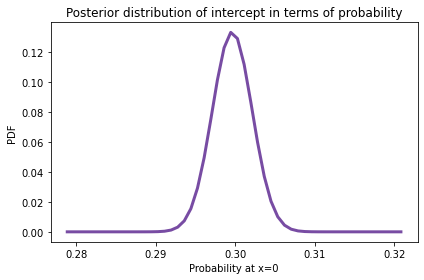

In [90]:
marginal_probs.plot(color='C4')
decorate(xlabel='Probability at x=0',
         ylabel='PDF',
         title='Posterior distribution of intercept in terms of probability')

The mean of this distribution is about 24%, which is the predicted probability of supporting legalization for someone born around 1949.

In [91]:
marginal_probs.mean(), offset

(0.29961602953948796, 1948.7242)

The estimated slope is the log of the likelihood ratio for each additional year of birth.  To interpret slopes as likelihood ratios, we can use `np.exp` to transform the values in the posterior distribution.

In [92]:
marginal_lr = transform(marginal_inter, np.exp)

And here's what it looks like.

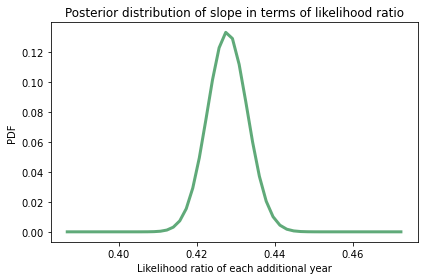

In [93]:
marginal_lr.plot(color='C2')

decorate(xlabel='Likelihood ratio of each additional year',
         ylabel='PDF',
         title='Posterior distribution of slope in terms of likelihood ratio')

The mean of this distribution is about 0.43, which indicates that each additional year is evidence that the respondent will say "yes", with a a likelihood ratio (or Bayes factor) of 0.43.

In [94]:
marginal_lr.mean()

0.42780656870625144

Later we will use the joint posterior distribution to generate predictions, but first I'll show how to compute likelihoods under a log transform.

## Log Likelihood

Because of the problem of underflow, many likelihood computations are done under a log transform.  That's why the distributions in SciPy, including `binom`, provide functions to compute logarithms of PMFs and PDFs.

Here's a loop that uses `binom.logpmf` to compute the log likelihood of the data for each pair of parameters in `joint_pmf`: 

In [95]:
log_likelihood = joint_pmf.copy()

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    log_likes = binom.logpmf(ks, ns, ps)
    log_likelihood[slope, inter] = log_likes.sum()

`log_likes` is an array that contains the logarithms of the binomial PMFs for each group.
The sum of these logarithms is the log of their product, which is the log-likelihood of the data.

Since the likelihoods are small, their logarithms are negative.  The smallest (most negative) is about -610; the largest (least negative) is about -480.

In [96]:
log_likelihood.min(), log_likelihood.max()

(-607.8199099184933, -480.8081879180253)

So the log likelihoods are comfortably with the range we can represent with floating-point numbers.

However, before we can do the update, we have to convert the logarithms back to a linear scale.  To do that while minimizing underflow, I am going to shift the logs up toward zero.

Adding a constant to the `log_likelihood` is the same as multiplying a constant by `likelihood`.  
We can do that without affecting the results because we have to normalize the posterior probabilities, so the multiplicative constant gets normalized away.

In [97]:
shifted = log_likelihood - log_likelihood.max()
likelihood2 = np.exp(shifted)

After subtracting away the largest element in `log_likelihood`, the range of values in the result is from -127 to 0.

In [98]:
shifted.min(), shifted.max()

(-127.01172200046801, 0.0)

So the range of likelihoods is from near 0 to 1.

In [99]:
likelihood2.min(), likelihood2.max()

(6.910508383385572e-56, 1.0)

Now we can use them as likelihoods in a Bayesian update.

In [100]:
posterior_pmf2 = joint_pmf * likelihood2
posterior_pmf2.normalize()

0.021604219991658798



To confirm that we get the same results using likelihoods or log-likelihoods, I'll compute the mean of the marginal posterior distributions:

In [101]:
joint_posterior2 = posterior_pmf2.unstack()

marginal2_inter = marginal(joint_posterior2, 0)
marginal2_slope = marginal(joint_posterior2, 1)

print(marginal2_inter.mean(), marginal2_slope.mean())

-0.8491556076374563 0.031694255696289274


And compare them to what we got using (non-log) likelihoods.

In [102]:
print(marginal_inter.mean(), marginal_slope.mean())

-0.8491556076374563 0.03169425569628929


They are the same except for small differences due to floating-point approximation.

In this example, we can compute the posterior distribution either way, using likelihoods or log likelihoods.
But if there were more data, the likelihoods would underflow and it would be necessary to use log likelihoods.

## Making predictions

As we did with the previous example, we can use the posterior distribution of the parameters to generate predictions, which we can use to see whether the model fits the data and to extrapolate beyond the data.

I'll start with a sample from the posterior distribution.

In [103]:
np.random.seed(42)

In [104]:
sample = posterior_pmf.sample(101)

And a range of `xs` that extends 20 years past the observed data.

In [105]:
xs = np.arange(1880, 2021) - offset

We can use the sampled parameters to predict probabilities for each group.

In [106]:
ps = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps[i] = expit(inter + slope * xs)
    
ps.shape

(101, 141)

But that only accounts for uncertainty about the parameters.

We also have to account for variability in the size of the groups.  Here's the distribution of group size, dropping the groups smaller than 20.

In [107]:
not_small = (data['count'] >= 20)
counts = data.loc[not_small, 'count']
counts.describe()

count    104.000000
mean     358.567308
std      232.895275
min       29.000000
25%      162.500000
50%      336.500000
75%      492.750000
max      846.000000
Name: count, dtype: float64

To simulate variation in group size, I'll use `np.random.choice` to resample the group sizes; that is, I'll draw from `counts` a sample with the same length as `xs`, sampling with replacement.

In [108]:
ns = np.random.choice(counts, len(xs), replace=True)
ns[:10]

array([718, 330, 842,  31,  31, 197, 782, 260,  78, 155])

Even if we know how many people are in each group and their probability of saying "yes", there is still uncertainty in the outcome.  We can use the binomial distribution to simulate this (final) source of uncertainty.

Putting it all together, the following loop combines these sources of uncertainty to generate predictive distributions for each group.

In [109]:
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    ps = expit(inter + slope * xs)
    ns = np.random.choice(counts, len(xs), replace=True)
    ks = binom(ns, ps).rvs(len(xs))
    pred[i] = ks / ns
    
pred.shape

(101, 141)

The result is an array with one row for each pair of parameters in the sample and one column for each value in `xs`.

Now we can use `np.percentile` to compute percentiles in each column.

In [110]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(141,)

And use them to plot a 90% credible interval for the predictions.

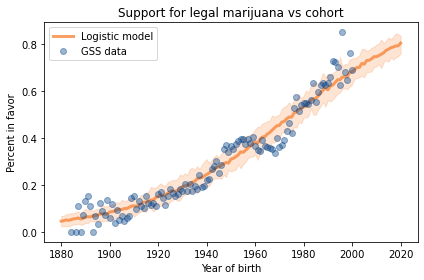

In [111]:
plt.fill_between(xs+offset, low, high, 
                 color='C1', alpha=0.2)

plt.plot(xs+offset, median, label='Logistic model', 
         color='C1')

plot_data(data)

The model fits the long-term trend of the data, with most data points falling within the 90% credible interval despite the apparent deviations from the trend.

The model predicts that people born between 2000 and 2020 will be more likely to support legalizing marijuana (when they are old enough to be respondents in the General Social Survey).

**Exercise:** The GSS dataset we used to explore generational changes contains more than 100 other variables related to the attitudes and beliefs of the respondents.  You can [read about these variables here](https://gssdataexplorer.norc.org/projects/52787).  Choose one and run an analysis similar to what we did with `grass`.

How well does the logistic model describe the long-term trend for the variable you chose?